In [1]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrdata.utils.bbox_utils import scale_XYWH_box
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/scratch2/wenlongzhao/anaconda3/envs/roost2021/lib/python3.6/site-packages/pyart/io/nexrad_level2.py:169: UserWarning: No MSG5 detected. Setting to meaningless data. Rethink your life choices and be ready for errors.Specifically fixed angle data will be missing
  warnings.warn("No MSG5 detected. Setting to meaningless data. "
/scratch2/wenlongzhao/anaconda3/envs/roost2021/lib/python3.6/site-packages/pyart/io/nexrad_archive.py:212: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6] for moment REF.
  UserWarning)


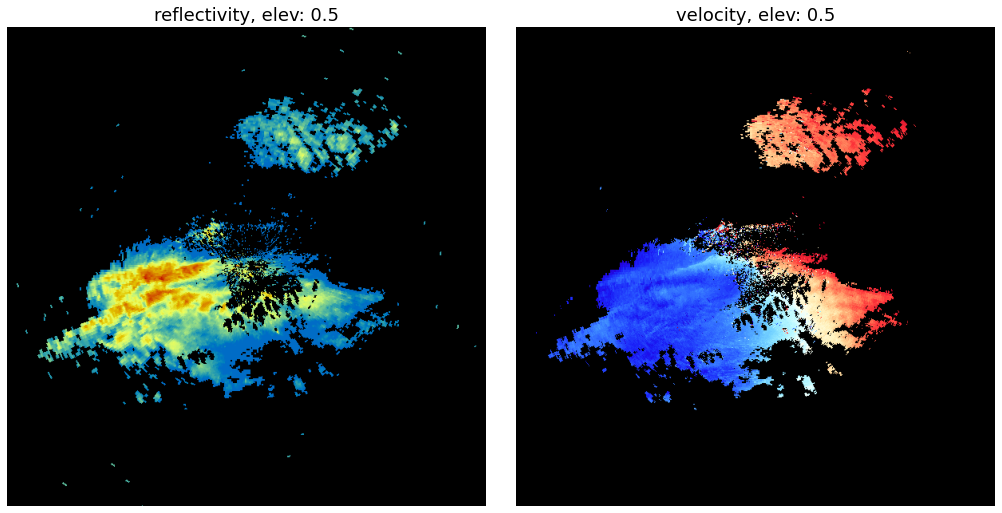

In [2]:
# Download a scan, pick channels, render and visualize arrays

from wsrdata.utils.s3_utils import download_scans

OUTPUT_DIR = "tmp"
KEY = "1996/03/01/KBUF/KBUF19960301_114428.gz"
ATTRIBUTES = ["reflectivity", "velocity"]
ELEVATIONS = [0.5]

os.makedirs(OUTPUT_DIR, exist_ok=True)
download_scans([KEY], OUTPUT_DIR)
radar = pyart.io.read_nexrad_archive(os.path.join(OUTPUT_DIR, KEY))
data, fields, elevs, y, x = radar2mat(radar,
                                      ydirection="xy", # default radar direction, y is first dim (row), large y is north, row 0 is south
                                      fields=ATTRIBUTES,
                                      coords='cartesian',
                                      r_max=150000,
                                      dim=600,
                                      elevs=ELEVATIONS,)

fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES), figsize=(7*len(ATTRIBUTES), 7*len(ELEVATIONS)), constrained_layout=True)

for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        if len(ATTRIBUTES) > 1 and len(ELEVATIONS) > 1:
            subplt = axs[j, i]
        elif len(ATTRIBUTES) > 1:
            subplt = axs[i]
        else:
            subplt = axs[j]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](data[i, j, :, :]))[:, :, :3] # omit the fourth alpha dimension
        subplt.imshow(rgb, origin='lower') # set the origin to lower so that north is the top of the image

plt.show()
plt.close(fig)

/scratch2/wenlongzhao/anaconda3/envs/roost2021/lib/python3.6/site-packages/pyart/io/nexrad_archive.py:212: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


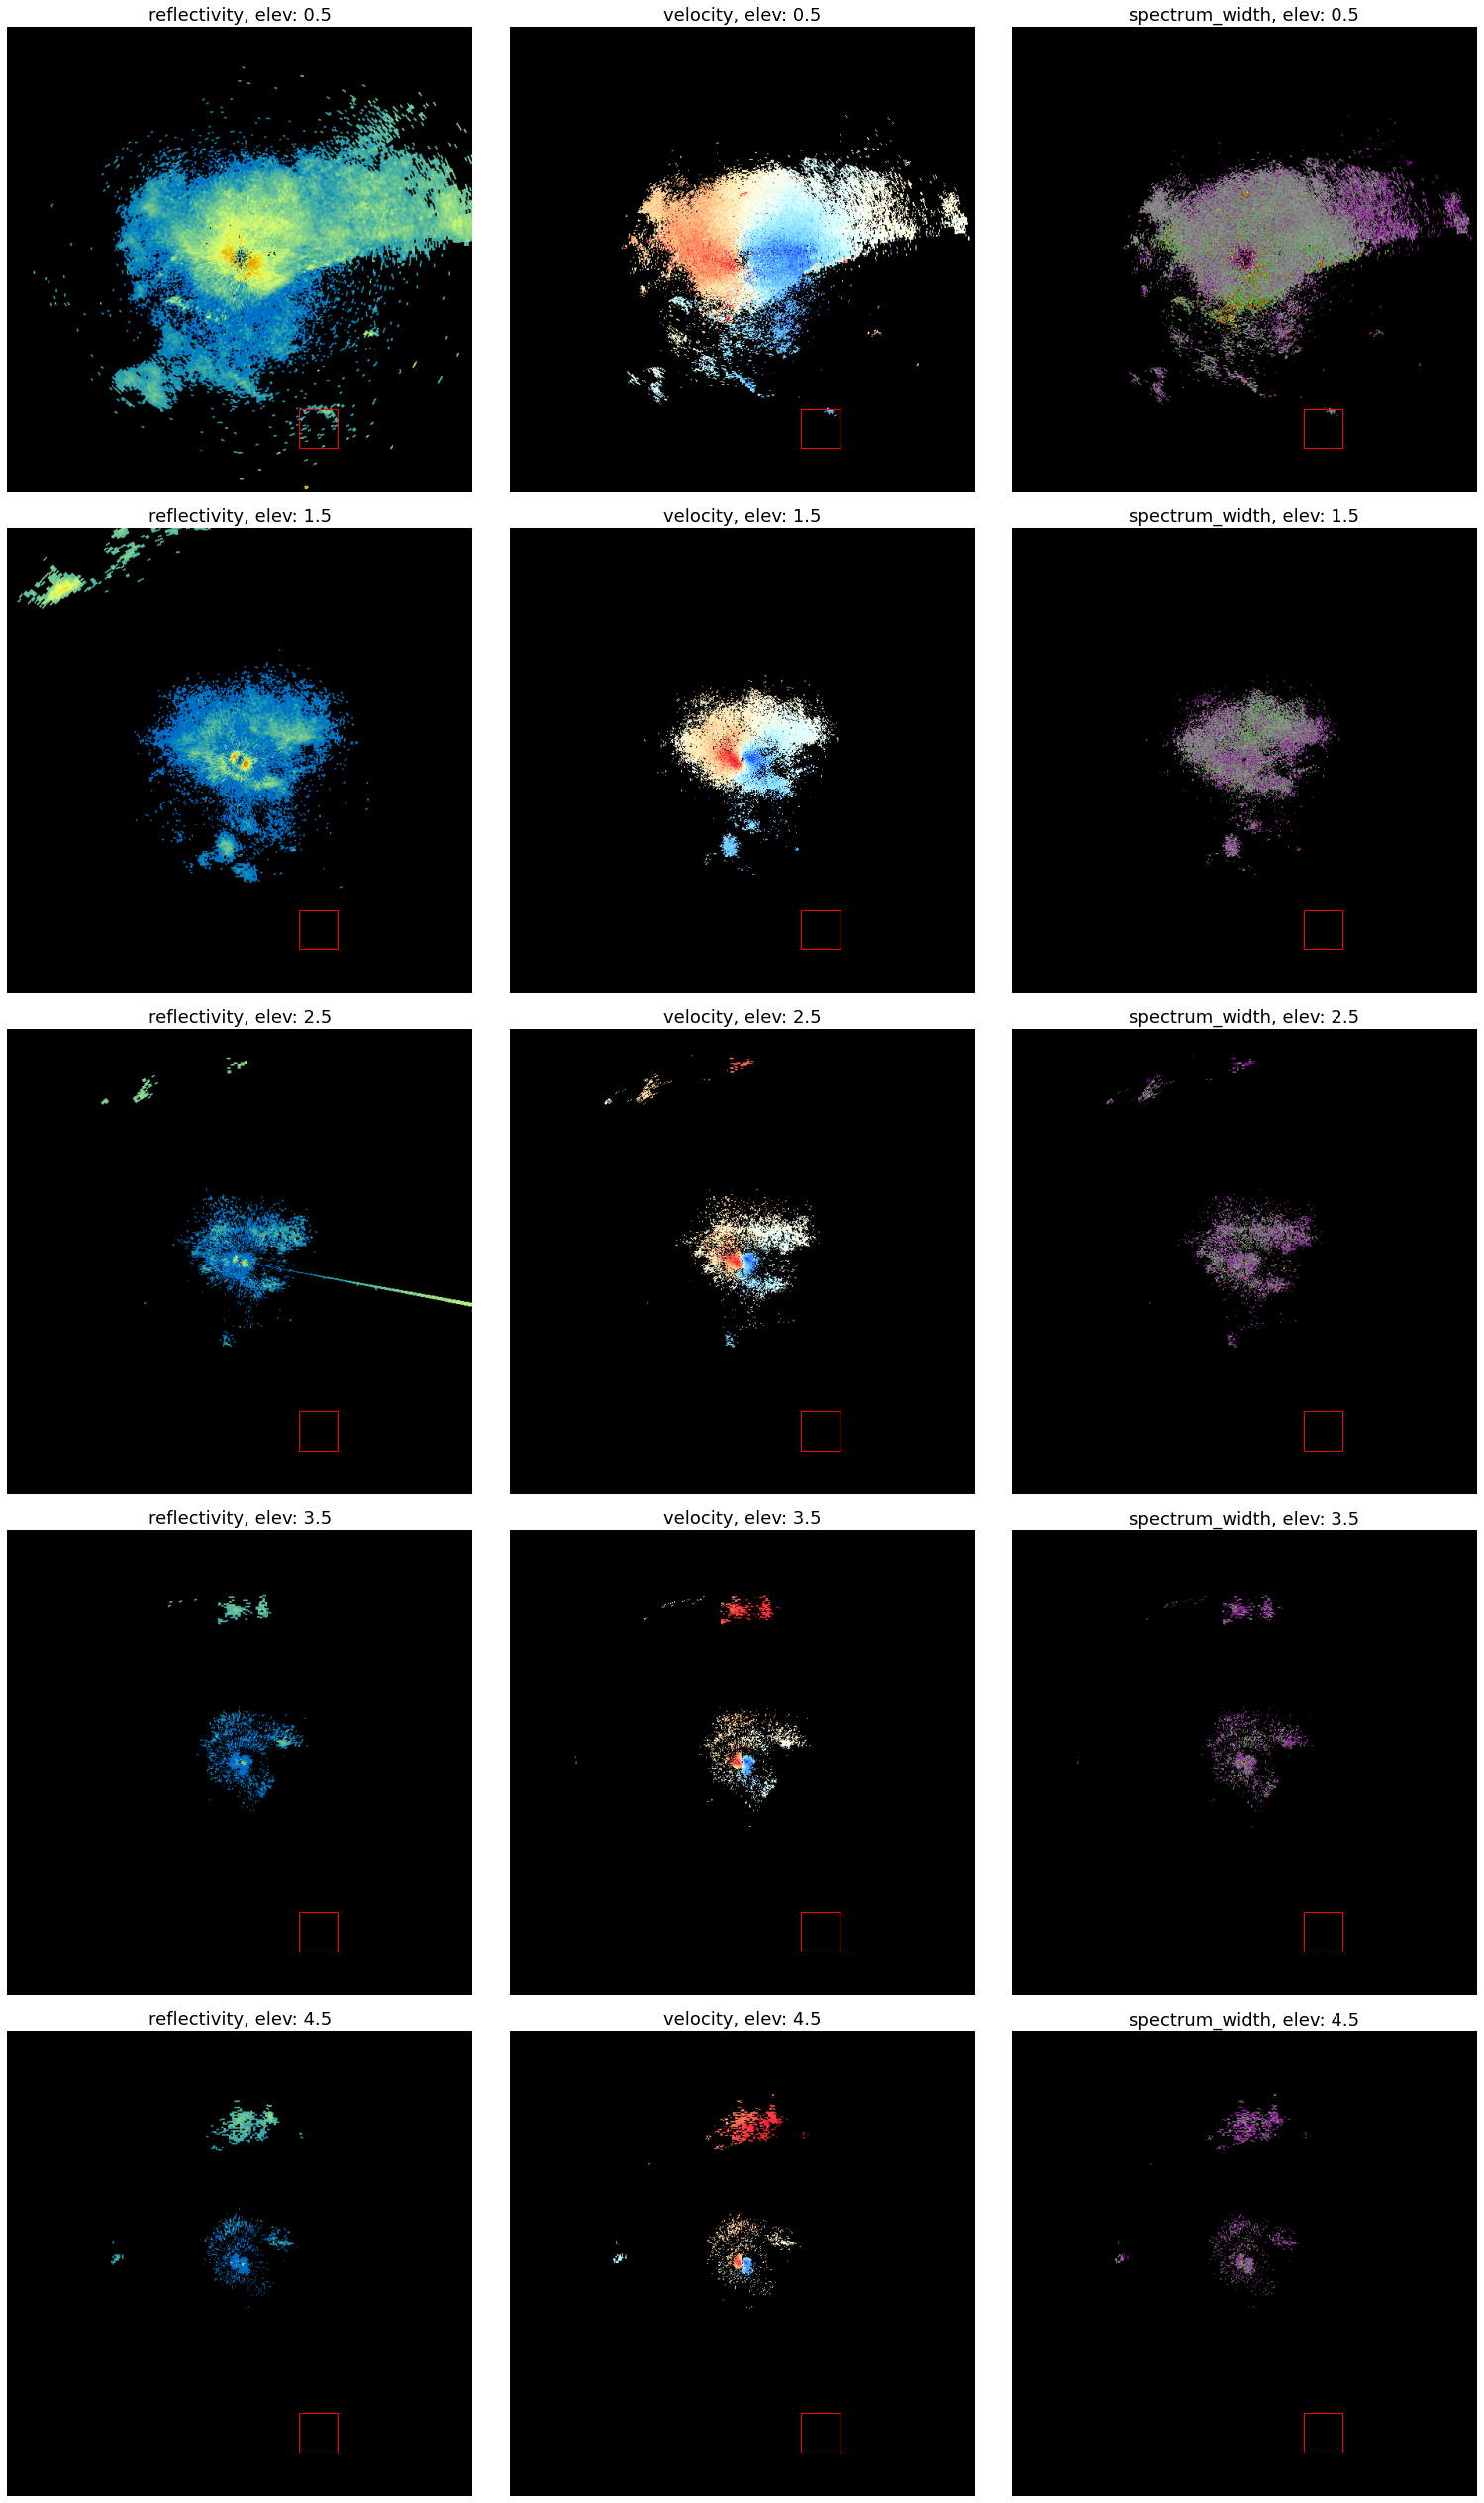

In [3]:
# Pick a downloaded scan
# Render arrays from the scan and visualize with annotations

SCAN = "KLIX19951013_121258"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"
    # /scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/2010/10/22/KAMX/KAMX20101022_105646_V03.gz
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

# render
radar = pyart.io.read_nexrad_archive(SCAN_FILE)
data, fields, elevs, y, x = radar2mat(radar,
                                      ydirection="xy", # default radar direction, y is first dim (row), large y is north, row 0 is south
                                      fields=ATTRIBUTES,
                                      coords='cartesian',
                                      r_max=150000,
                                      dim=600,
                                      elevs=ELEVATIONS,)

# set up plot grid
fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES), figsize=(7*len(ATTRIBUTES), 7*len(ELEVATIONS)), constrained_layout=True)

# get bbox
im_x, im_y, im_r = 50795.5, -109014.5, 12647.054074546 # annotations on the scale of -150000m to 150000m from the radar station
im_x = (im_x + 150000) * 600 / (2 * 150000)
im_y = (im_y + 150000) * 600 / (2 * 150000)
im_r = im_r * 600 / (2 * 150000)
def xyr2bbox(x_im, y_im, r_im): # not scaled, user annotation bias remains
    xy = np.array((int(x_im - r_im), int(y_im - r_im)))
    w = int(x_im + r_im) - int(x_im - r_im)
    h = int(y_im + r_im) - int(y_im - r_im)
    return xy, w, h
xy, w, h = xyr2bbox(im_x, im_y, im_r)

# plot
for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        subplt = axs[j, i]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](data[i, j, :, :]))[:, :, :3] # omit the fourth alpha dimension
        subplt.imshow(rgb, origin='lower') # set the origin to lower so that north is the top of the image
        rect = patches.Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='none')
        subplt.add_patch(rect)

plt.show()
plt.close(fig)

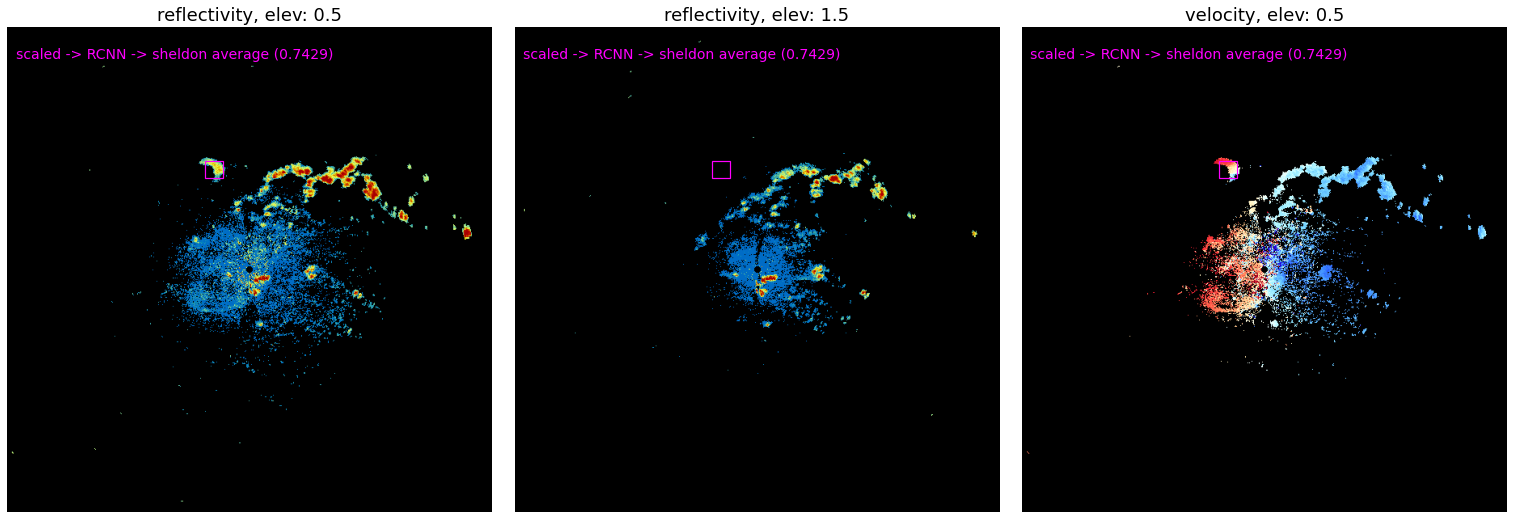

In [4]:
# Input json, pick a downloaded scan whose arrays are rendered, and channels
# Visualize array channels with annotations from json

# define which scan to visualize, which json to be the source of annotations
SCAN = "KAMX20101024_112106_V03"
CHANNELS = [("reflectivity", 0.5), ("reflectivity", 1.5), ("velocity", 0.5)]
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts_v0.0.1/roosts_v0.0.1.json"

# colors for bboxes
color_array = [
    '#006400', # for not scaled boxes
    '#FF00FF', # scaled to RCNN then to user factor 0.7429 which is sheldon average
    '#800080',
    '#FFA500',
    '#FFFF00'
]

with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
scan_to_id = {}
for scan in dataset["scans"]:
    scan_to_id[scan["key"]] = scan["id"]
attributes = dataset["info"]["array_fields"]
elevations = dataset["info"]["array_elevations"]

scan = dataset["scans"][scan_to_id[SCAN]]
array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))["array"]

fig, axs = plt.subplots(int(np.ceil(len(CHANNELS)/3)), 3,
                        figsize=(21, 7*int(np.ceil(len(CHANNELS)/3))),
                        constrained_layout=True)

for i, (attr, elev) in enumerate(CHANNELS):
    subplt = axs[i]
    subplt.axis('off')
    subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
    cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
    rgb = cm(NORMALIZERS[attr](array[attributes.index(attr), elevations.index(elev), :, :]))
    rgb = rgb[:, :, :3] # omit the fourth alpha dimension, NAN are black but not white
    subplt.imshow(rgb, origin='lower') # set the origin to lower so that north is the top of the image
    for annotation_id in scan["annotation_ids"]:
        bbox = dataset["annotations"][annotation_id]["bbox"]
        subplt.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                          fill=False,
                          edgecolor=color_array[1], 
                          linewidth=1.2)
        )
        subplt.text(10, 560, 'scaled -> RCNN -> sheldon average (0.7429)', 
                    bbox=dict(facecolor='white', alpha=0), fontsize=14, color=color_array[1])

plt.show()
plt.close(fig)

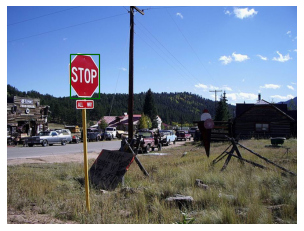

In [5]:
# visualize a random image with annotations from coco-2017 val data
# to confirm that we are using the same bbox format as coco

# define which scan to visualize, which json to be the source of annotations
IMAGE = "tmp/000000222094.jpg"
CHANNELS = [("reflectivity", 0.5), ("reflectivity", 1.5), ("velocity", 0.5)]
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts_v0.0.1/roosts_v0.0.1.json"
BBOX = [107.87,81.74,49.71,75.0]

rgb = plt.imread(IMAGE)

fig, axs = plt.subplots()

# subplt = axs[i]
axs.axis('off')
axs.imshow(rgb) # set the origin to lower so that north is the top of the image
axs.add_patch(
    plt.Rectangle((BBOX[0], BBOX[1]), BBOX[2], BBOX[3],
                  fill=False,
                  edgecolor='#006400', 
                  linewidth=1.2)
)

plt.show()
plt.close(fig)

In [6]:
# Input json, pick a downloaded scan whose arrays are rendered, and channels
# Save array channels with colormap as images as if preparing data for UI
from matplotlib import image

# define which scan to visualize, which json to be the source of annotations
SCAN = "KAMX20101024_112106_V03"
CHANNELS = [("reflectivity", 0.5), ("reflectivity", 1.5), ("velocity", 0.5)]
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts_v0.0.1/roosts_v0.0.1.json"
OUTPUT_DIR = "tmp"

os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
scan_to_id = {}
for scan in dataset["scans"]:
    scan_to_id[scan["key"]] = scan["id"]
attributes = dataset["info"]["array_fields"]
elevations = dataset["info"]["array_elevations"]

scan = dataset["scans"][scan_to_id[SCAN]]
array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))["array"]

for i, (attr, elev) in enumerate(CHANNELS):
    cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
    rgb = cm(NORMALIZERS[attr](array[attributes.index(attr), elevations.index(elev), :, :]))
    rgb = rgb[::-1, :, :3] # flip the y axis; omit the fourth alpha dimension, NAN are black but not white
    image.imsave(os.path.join(OUTPUT_DIR, f"example_ui_image_{attr}{elev}.png"), rgb)
    